# Work for Tom Sargent
By Brandon Kaplowitz

Date: June 1, 2018 

## Problem 1.1 from "Marching Orders"
### Description of the Problem
We take from 0 to T $$y_t=\theta_ty_{t-1} + \varepsilon_t$$ $$ \theta_{t+1} = \theta_t+\nu_t $$
where  
$$
\begin{equation}
\left(\begin{matrix}
\varepsilon_t \\
\nu_t 
\end{matrix}\right) \sim \mathcal{N}\left(0,V\right) \ \text{and}  \ V= \left[ \begin{matrix} 
R & C \\
C & Q 
\end{matrix}\right].
\end{equation}
$$
We suppose initial state $\theta_0$ and $V$ are independent and their natural conjugate priors are
 $$\theta_0 \sim \mathbb{1}_{|\theta|<1}\mathcal{N}\left(\bar{\theta},\bar{P}\right) $$
 and 
 $$ V\sim \mathcal{IW}\left(\bar{V}^{-1}, T_0\right)$$ 
 where $\mathcal{IW}\left(S,df\right)$ is the inverse wishart distribution with scale matrix $S$ and degrees of freedom $df$. We suppose that $\left(\bar{\theta}, \bar{P}, \bar{V}^{-1} , T_0\right)$ are known and fixed.
 
 We  treat $\theta_t$ as a hidden state variable following a driftless random walk with the truncated Gaussian distribution:
 
 $$p\left(\theta_{t+1}|\theta_t,V\right) \propto \mathbb{1}_{|\theta_{t+1}| <1} \mathcal{N}\left(\theta_t,Q\right).$$
 
### Description of Algorithm

To solve this problem, we need to take the priors $\theta_0 \sim \mathbb{1}_{|\theta|<1}\mathcal{N}\left(\bar{\theta}, \bar{P}\right)$ and $V \sim \mathcal{IW}\left(\bar{V}^{-1}, T_0\right)$ and multiply them by their likelihoods to find their posteriors. The posterior is $$p\left(\theta^T,V|y^T\right) \underbrace{=}_{\text{By Bayes' Rule}} \frac{p\left(y^T|\theta^T,V\right)p\left(\theta^T,V\right)}{p\left(y^T\right)}= \frac{p\left(y^T|\theta^T,V
\right)p\left(\theta^T|V\right)p\left(V\right)}{p\left(y^T\right)}$$
$$ =\frac{\prod_{t=1}^{T}p\left(y_t|y_{t-1},\theta^T,V\right)\prod_{t=1}^{T}p\left(\theta_{t+1}|\theta_{t},V\right)p\left(\theta_0\right)p\left(V\right)}{p\left(y^T\right)} $$
We can see now that the first term is the likelihood, the second the Bayesian updating of $\theta$ from a prior on $\theta$ to a posterior on $\theta_t$ given the $\theta$ before it, and the last two terms the prior for $\theta_0$ and $V$. 
Note that: $$p\left(y_t|y_{t-1}, \theta^T,V\right)=  p\left(\theta_t y_{t-1}+\varepsilon_t|\theta_t, y_{t-1},\varepsilon_{t-1} \right)\underbrace{=}_{iid}p\left(\varepsilon_t\right) \sim \mathcal{N}\left(\theta_t y_{t-1},R\right)$$
$$p\left(\theta_{t+1} | \theta_{t},V\right) \propto \mathbb{1}_{|\theta_{t+1}|<1}\mathcal{N}\left(\theta_t,Q\right)$$

The procedure we use is as follows. We use a modification to MCMC called HMC, as well as the Metropolis-Hastings for speed comparison. We compute the numerator of the fraction given above to give a conditional pdf. We then take a proposal distribution, draw a new point from the proposal. If the ratio of the numerator of the new point to the old point is greater than 1 we accept. Otherwise we accept with the probability of the ratio times a correction for asymmetric distributions. We can ignore the denominator as we are examining the ratio of two pdfs, both of which will have the same denominator, which is a normalization.
We now implement this procedure in PYMC3.
## Implementation

To actually implement this model, since $p(y_t|y_{t-1},\theta^T,V)$ is incredibly difficult to calculate explicitly, we will use the built in Hierarchical GLM modeller in PYMC3. 

The model we will use looks as follows:

![title](Source.gv.png)

In [1]:
%reset -f
%pylab inline
import pymc3 as pm
import numpy as np
import matplotlib
from matplotlib import rc
import seaborn as sns
import theano as theano
rc('font',**{'family':'sans-serif','sans-serif':['DejaVu Sans']})
matplotlib.rcParams['mathtext.fontset'] = 'stixsans'
import matplotlib.pylab as plt 
plt.rc('mathtext', fontset="cm")
import scipy.stats as st
from pymc3.distributions import Continuous, Normal, MvNormal

import theano.tensor as tt
from theano import scan
from pymc3.util import get_variable_name
from pymc3.distributions.continuous import get_tau_sd, Normal, Flat
from pymc3.distributions.dist_math import Cholesky
from pymc3.distributions import multivariate
from pymc3.distributions import distribution
matplotlib.rcParams['font.sans-serif']='DejaVu Sans'
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
plt.style.use('ggplot')

Populating the interactive namespace from numpy and matplotlib


WARNING (theano.configdefaults): Only clang++ is supported. With g++, we end up with strange g++/OSX bugs.
/Users/bkaplowitz-local/anaconda3/envs/idp/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
T=50
theta_true=np.empty([T+1,1])
nu=np.empty([T+1,1])
y_obs=np.empty([T+1,1])
y_obs_last = np.empty([T+1,1])
y_obs[0]=0
y_obs_last[0]=0
theta_true[0]=.3
errs=st.multivariate_normal.rvs(mean=[0.,0.], cov=[[2.0, 0.3], [0.3, 0.5]], size=T+1)
nu=errs[:,0]
err=errs[:,1]
for t in range(1,T):
    theta_true[t+1]=theta_true[t]+nu[t]
    while (theta_true[t+1]>1 or theta_true[t+1]<-1):
        theta_true[t+1]=st.norm.rvs(loc=theta_true[t], scale=np.sqrt(.5))
    y_obs[t]= theta_true[t]*y_obs[t-1]+err[t]
    y_obs_last[t]=y_obs[t-1]
#fix constant values.

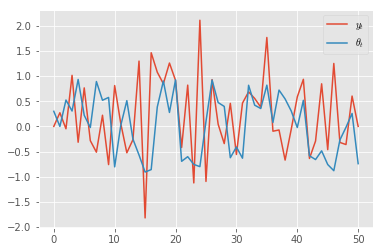

In [3]:
plt.plot(y_obs, label=r'$y_t$') 
plt.plot(theta_true,label=r'$\theta_t$')
plt.legend()

In [4]:
#define the likelihood function used
class univautoreg(Continuous):
    def __init__(self,theta0=None, v=None,nu=None, *args, **kwargs):
        super(univautoreg, self).__init__(*args, **kwargs)
        self.theta0 = theta0
        BoundedNormal = pm.Bound(pm.Normal, lower=-1, upper=1)
        T=50 #number of samples
        self.mean = tt.as_tensor_variable(0.)
        self.v=v
        def calc_next_theta(last_theta,nu):
            theta=last_theta+nu
            last_theta=theta
            return theta
        thetas_list, _ = scan(fn=calc_next_theta, 
                             outputs_info=[theta0],
                             non_sequences=[nu],
                             n_steps=T
                             )
        theta=thetas_list
        self.theta=theta
    def logp(self,value):
        theta=self.theta
        theta0=self.theta0
        v=self.v
        valuenew=value.flatten()
        def calc_next_err(last_value,value,theta_t,theta_t1,vin):
            this_period=[value,theta_t1]
            meanval=theta_t*last_value
            last_period=[meanval,theta_t]
            new_last=pm.math.stack(last_period)
            new_this=pm.math.stack(this_period)
            err = new_this-new_last
            lik= MvNormal.dist(mu=np.zeros(2), cov=vin).logp(err)
            return lik
        err_like, _  = scan(fn=calc_next_err,
                         sequences=[dict(input=valuenew, taps=[0,-1]),dict(input=theta, taps=[0,-1])],
                         outputs_info=[None],
                         non_sequences=[v]
                        )
        liketotal=tt.sum(err_like)
        return (liketotal)
        '''
  
                return (tt.sum(Normal.dist(mu=0.,sd=Q).logp(eps))+self.theta_lik_get(R,theta,theta_0)+Normal.dist(mu=0.,sd=Q).logp(y[0]))
        ''' 
        #if doesn't solve pr 

In [5]:
#Parameters needed to make model work.
theta_bar = .5
P_bar = .4
P_bar_sd = np.sqrt(P_bar)
V_bar = [[2,3],[3,4]]
T_0 =.2
with pm.Model() as model1:
    #Variance function
    sd_dist= pm.HalfCauchy.dist(beta=2.5,shape=3)
    BoundedNormal = pm.Bound(pm.Normal, lower=-1, upper=1)
    packed_chol = pm.LKJCholeskyCov('packed_chol', n=2, eta= 2, sd_dist=sd_dist ) #equivalent of p(V)
    chol = pm.expand_packed_triangular(2, packed_chol, lower=True)
    theta_prior= BoundedNormal('theta_prior',mu=theta_bar, sd=P_bar_sd)
    v=pm.Deterministic('v',chol.dot(chol.T))
    sdtemp=pm.Deterministic('sdtemp',tt.sqrt(tt.diag(v)))
    sd = pm.Deterministic('sd',tt.sum(tt.set_subtensor(sdtemp[0],sdtemp[1])/2))
    nu=BoundedNormal('nu',mu=0., sd= sd)
    like = univautoreg('like', theta0=theta_prior, v=v,nu=nu, observed=y_obs)
    start = pm.find_MAP()
    step = pm.Metropolis() #pm.NUTS()
    tracemodel1 = pm.sample(100000,step,start=start)

logp = -inf, ||grad|| = 10.463: 100%|██████████| 32/32 [00:00<00:00, 35.22it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [nu_interval__]
>Metropolis: [theta_prior_interval__]
>Metropolis: [packed_chol_cholesky_cov_packed__]
100%|██████████| 100500/100500 [48:55<00:00, 34.23it/s]
The estimated number of effective samples is smaller than 200 for some parameters.


In [11]:
pm.summary(tracemodel1)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
packed_chol__0,6.612599e+01,4.997531e-10,1.421085e-15,6.612599e+01,6.612599e+01,2.00003,0.999995
packed_chol__1,6.145727e-02,7.947115e-14,6.938894e-19,6.145727e-02,6.145727e-02,2.00003,0.999995
packed_chol__2,1.040466e-13,5.103236e-25,1.262177e-30,1.040466e-13,1.040466e-13,2.00003,0.999995
theta_prior,-4.376599e-01,2.220446e-16,1.110223e-17,-4.376599e-01,-4.376599e-01,2.00003,0.999995
v__0_0,4.372647e+03,2.453453e-08,0.000000e+00,4.372647e+03,4.372647e+03,2.00003,0.999995
v__0_1,4.063923e+00,1.525446e-11,0.000000e+00,4.063923e+00,4.063923e+00,NaN,0.999995
v__1_0,4.063923e+00,1.525446e-11,0.000000e+00,4.063923e+00,4.063923e+00,NaN,0.999995
v__1_1,3.776996e-03,3.090887e-14,4.336809e-20,3.776996e-03,3.776996e-03,2.00003,0.999995
sdtemp__0,6.612599e+01,4.997531e-10,1.421085e-15,6.612599e+01,6.612599e+01,2.00003,0.999995
sdtemp__1,6.145727e-02,7.947115e-14,6.938894e-19,6.145727e-02,6.145727e-02,2.00003,0.999995


In [12]:
pm.hpd(tracemodel1)

{0: {'packed_chol_cholesky_cov_packed__': array([[  4.19156189,   4.19156189],
         [  0.06145727,   0.06145727],
         [-29.8939376 , -29.8939376 ]]),
  'theta_prior_interval__': array([-0.93866525, -0.93866525]),
  'nu_interval__': array([0.15875548, 0.15875548]),
  'packed_chol': array([[6.61259920e+01, 6.61259920e+01],
         [6.14572721e-02, 6.14572721e-02],
         [1.04046592e-13, 1.04046592e-13]]),
  'theta_prior': array([-0.43765993, -0.43765993]),
  'v': array([[[4.37264682e+03, 4.37264682e+03],
          [4.06392308e+00, 4.06392308e+00]],
  
         [[4.06392308e+00, 4.06392308e+00],
          [3.77699629e-03, 3.77699629e-03]]]),
  'sdtemp': array([[6.61259920e+01, 6.61259920e+01],
         [6.14572721e-02, 6.14572721e-02]]),
  'sd': array([0.06145727, 0.06145727]),
  'nu': array([0.07921144, 0.07921144])},
 1: {'packed_chol_cholesky_cov_packed__': array([[  4.19156189,   4.19156189],
         [  0.06145727,   0.06145727],
         [-29.8939376 , -29.8939376 ]]),


In [13]:
pm.quantiles(tracemodel1)

{0: {'packed_chol_cholesky_cov_packed__': {2.5: array([  4.19156189,   0.06145727, -29.8939376 ]),
   25: array([  4.19156189,   0.06145727, -29.8939376 ]),
   50: array([  4.19156189,   0.06145727, -29.8939376 ]),
   75: array([  4.19156189,   0.06145727, -29.8939376 ]),
   97.5: array([  4.19156189,   0.06145727, -29.8939376 ])},
  'theta_prior_interval__': {2.5: -0.9386652478398483,
   25: -0.9386652478398483,
   50: -0.9386652478398483,
   75: -0.9386652478398483,
   97.5: -0.9386652478398483},
  'nu_interval__': {2.5: 0.15875547876581625,
   25: 0.15875547876581625,
   50: 0.15875547876581625,
   75: 0.15875547876581625,
   97.5: 0.15875547876581625},
  'packed_chol': {2.5: array([6.61259920e+01, 6.14572721e-02, 1.04046592e-13]),
   25: array([6.61259920e+01, 6.14572721e-02, 1.04046592e-13]),
   50: array([6.61259920e+01, 6.14572721e-02, 1.04046592e-13]),
   75: array([6.61259920e+01, 6.14572721e-02, 1.04046592e-13]),
   97.5: array([6.61259920e+01, 6.14572721e-02, 1.04046592e-13]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0xa38fa74e0>,
      dtype=object)

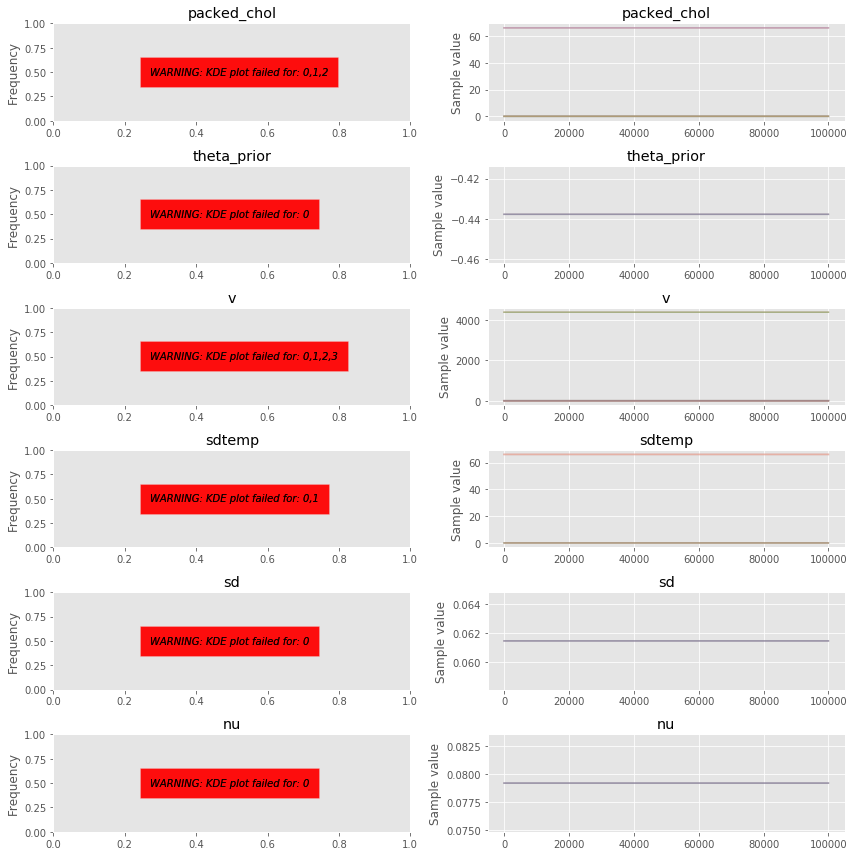

In [14]:
pm.traceplot(tracemodel1[:], alpha=.3)

ValueError: object too deep for desired array

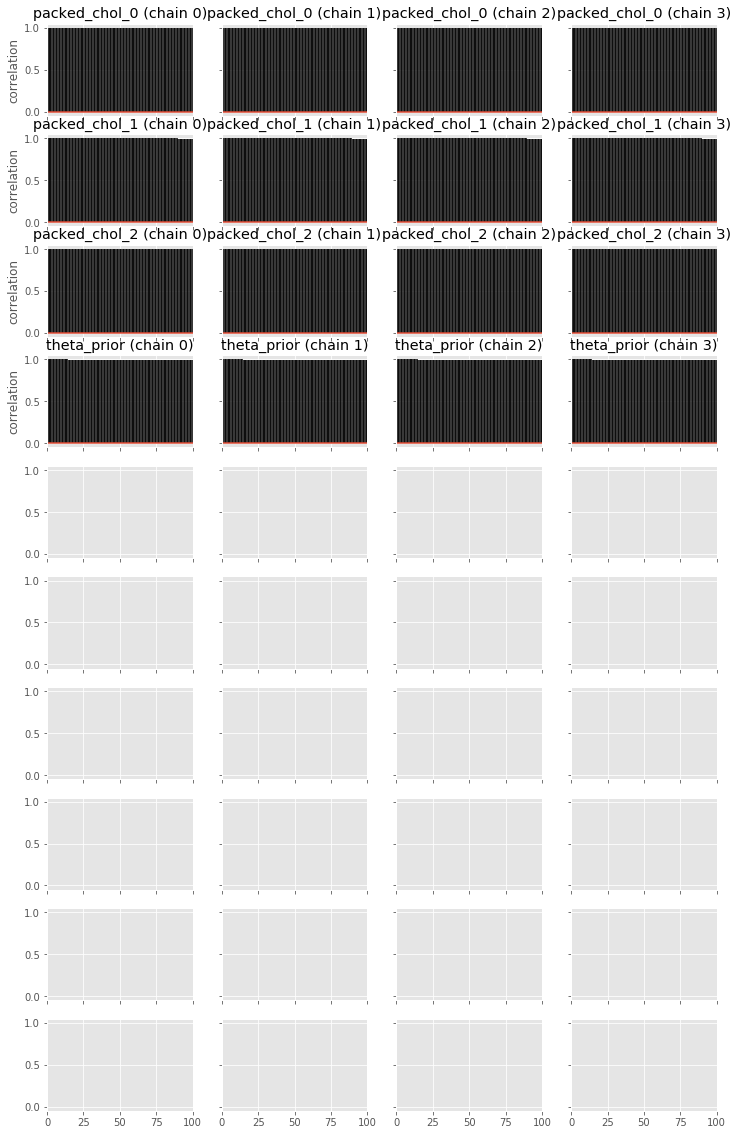

In [15]:
pm.autocorrplot(tracemodel1[10::2])

In [ ]:
sns.kdeplot(tracemodel1[::2]['theta_prior'])

In [ ]:
sns.kdeplot(tracemodel1[::2]['nu'])

In [ ]:
postpred=pm.sample_ppc(tracemodel1, samples=1000, model=model1)

In [ ]:
model1.observed_RVs

In [ ]:
plt.hist(postpred['like'], alpha=0.2, normed=True)
sns.kdeplot(tr1['mu']);